✍ Мы рассмотрели, как определяются потенциальные параметры разбиения $j$ и $t$ при построении одной конкретной вершины дерева. Настало время познакомиться с самим процессом разбиения или, как его ещё называют, **ветвлением**.

# **ВЕТВЛЕНИЕ. НЕОДНОРОДНОСТЬ**

Для начала нам потребуется немного сухой математики, а затем мы перейдём к конкретным примерам и посмотрим, как введённые нами формулы работают на практике.

Как и ранее, обозначим пару внутренних параметров корневой вершины $j$ и $t$ для краткости в виде вектора $w = (j, t)$, где $j$ — номер признака, а $t$ — пороговое значение.

Пары объектов и ответов $y$, соответствующих им, обозначим как $Q = (x, y)$. Пусть это множество $Q$ содержит $N = |Q|$ объектов из обучающей выборки.

Как сильно ответы в выборке $Q$ различаются между собой? Иначе говоря, какой разброс целевой переменной в выборке $Q$?

Чтобы это измерить, введём некоторую функцию $H(Q)$, которую назовём **критерием неоднородности** *(impurity criterion)* или **критерием информативности** (это более распространённое название). 

### **Примечание.** Часто в литературе можно встретить другие обозначения термина неоднородности: неопределённость, хаос, примесь, загрязнённость.

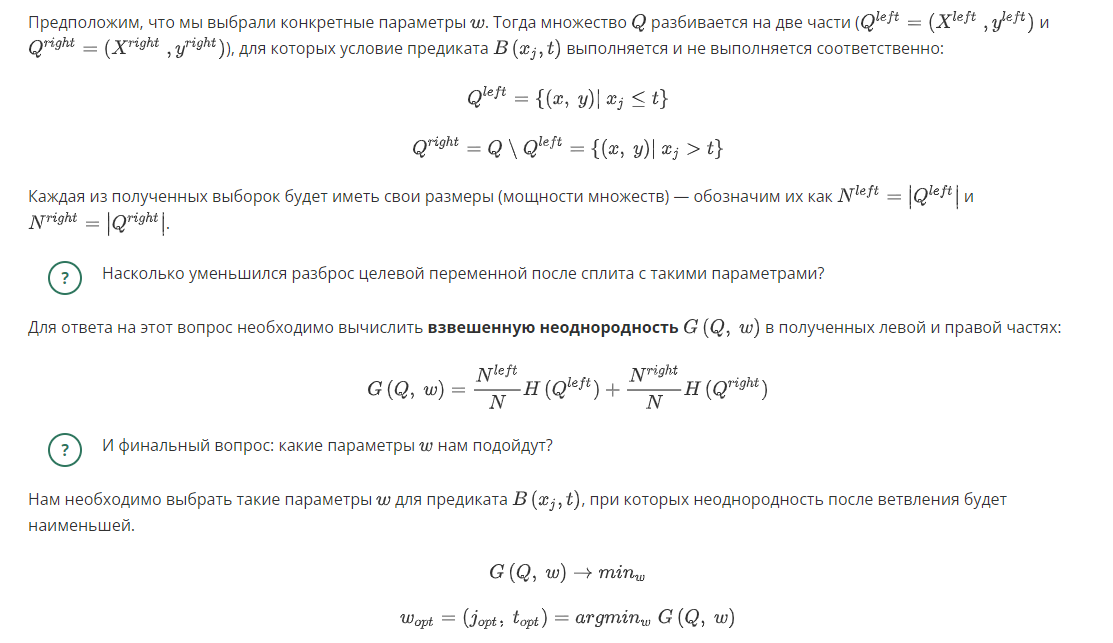

От вида функции $H(Q)$ зависит, как будет выглядеть итоговое выражение для неоднородности — её значение должно уменьшаться с уменьшением разброса ответов на выборке.

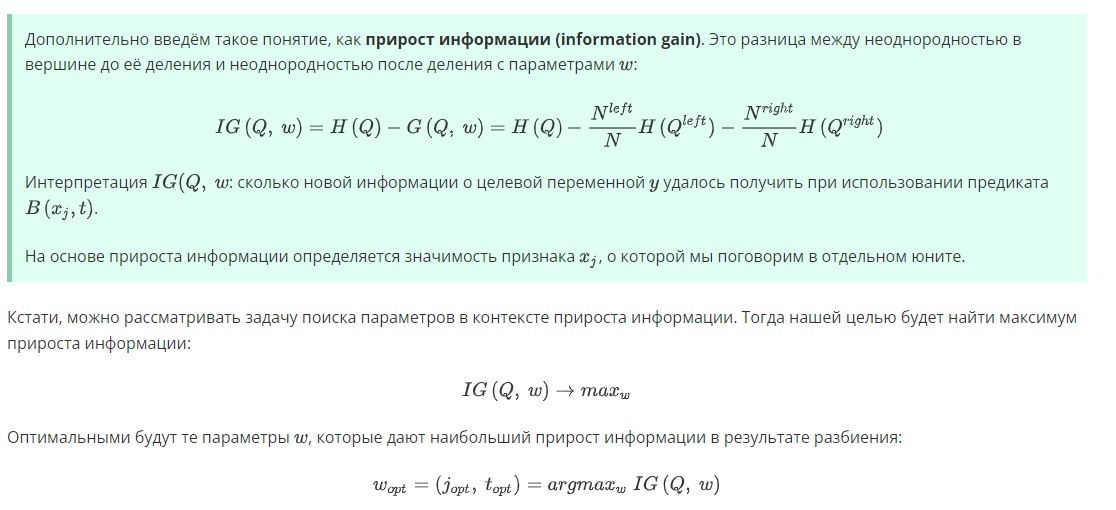

Чтобы завершить изучение процедуры построения решающего пня, нам осталось определиться с тем, как измерять неоднородность, иначе говоря, нам нужно определить, какие бывают **критерии информативности**. Вид критерия зависит от задачи, которую мы решаем. Для начала обсудим критерии информативности в задачах регрессии, а затем поговорим о задаче классификации.

# **КРИТЕРИИ ИНФОРМАТИВНОСТИ В ЗАДАЧЕ РЕГРЕССИИ**

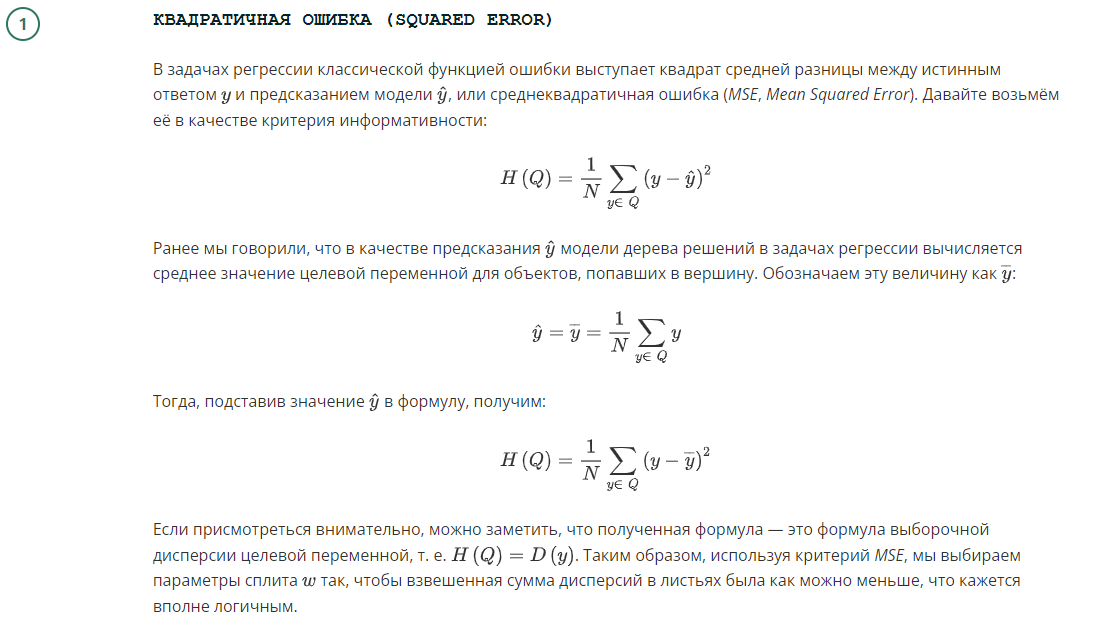

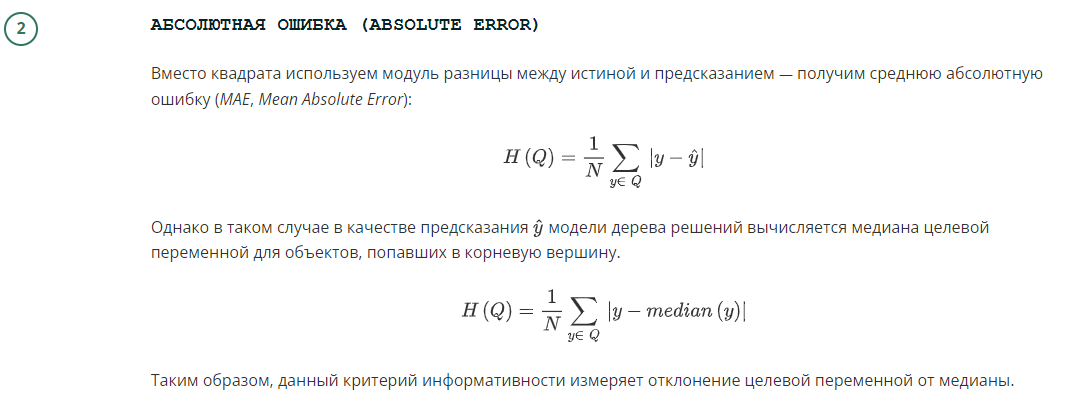

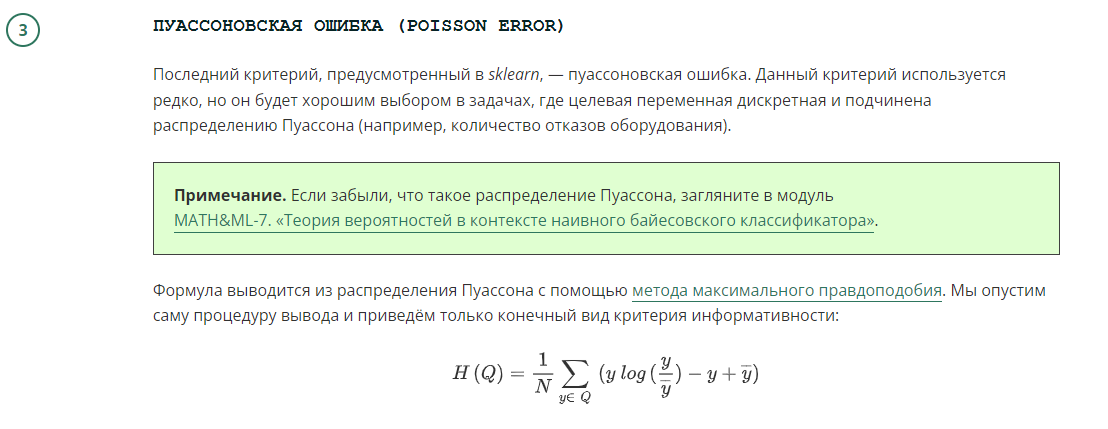

Давайте на примере квадратичной ошибки рассмотрим, как работают введённые нами формулы ↓

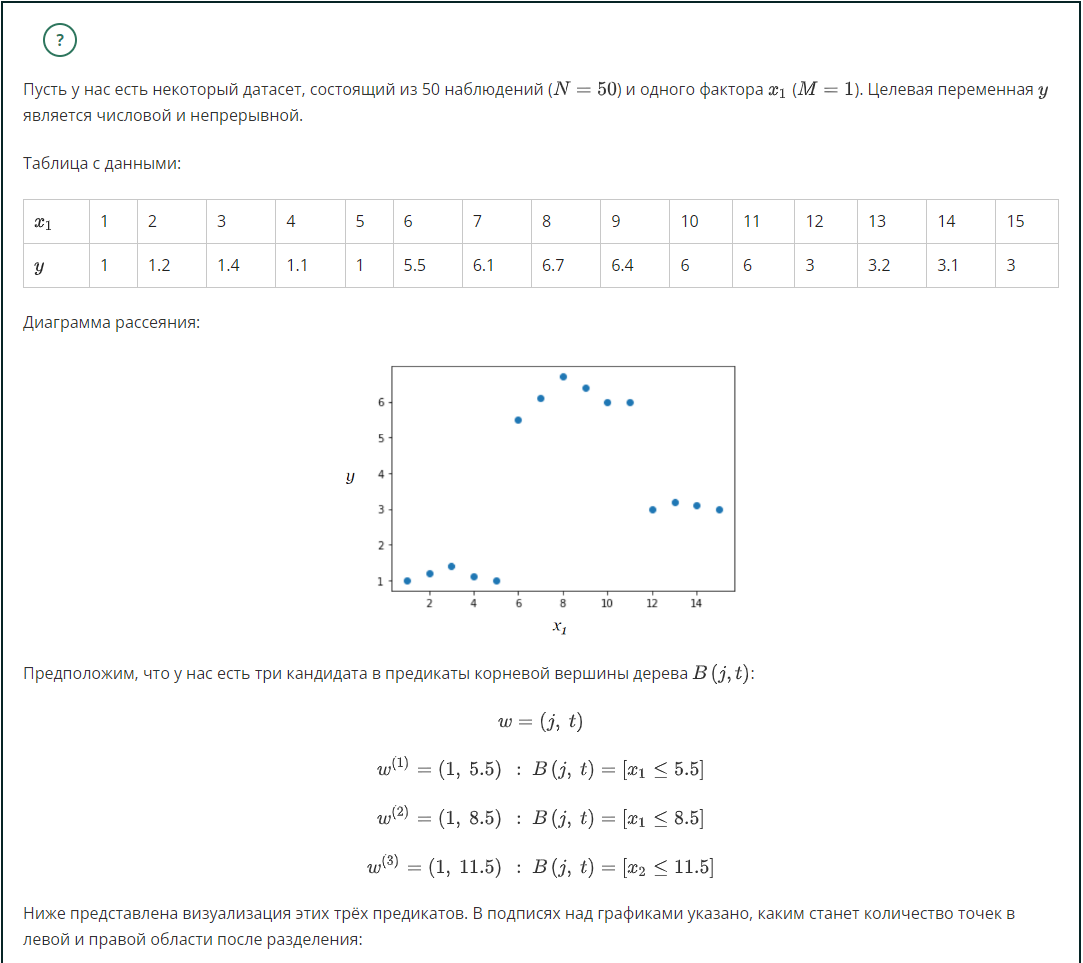

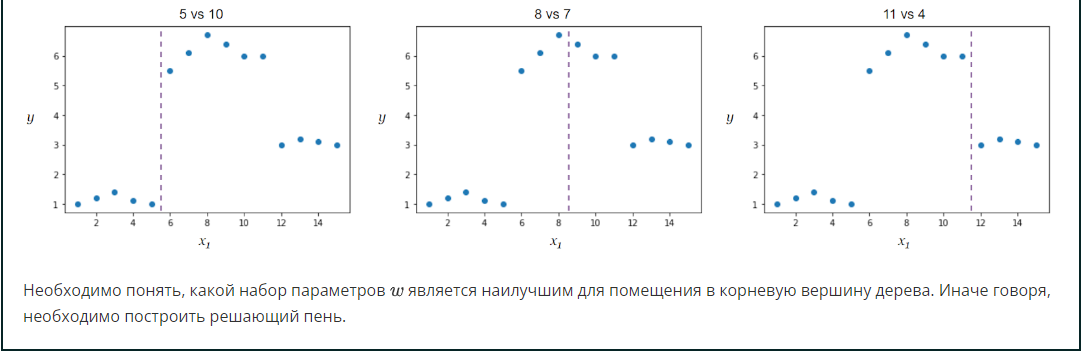

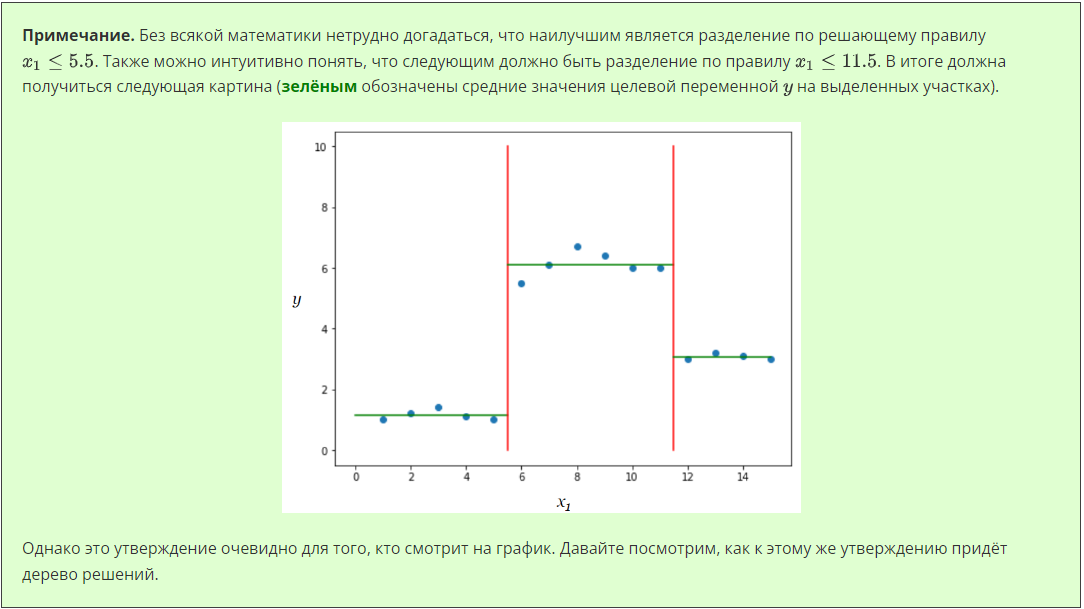

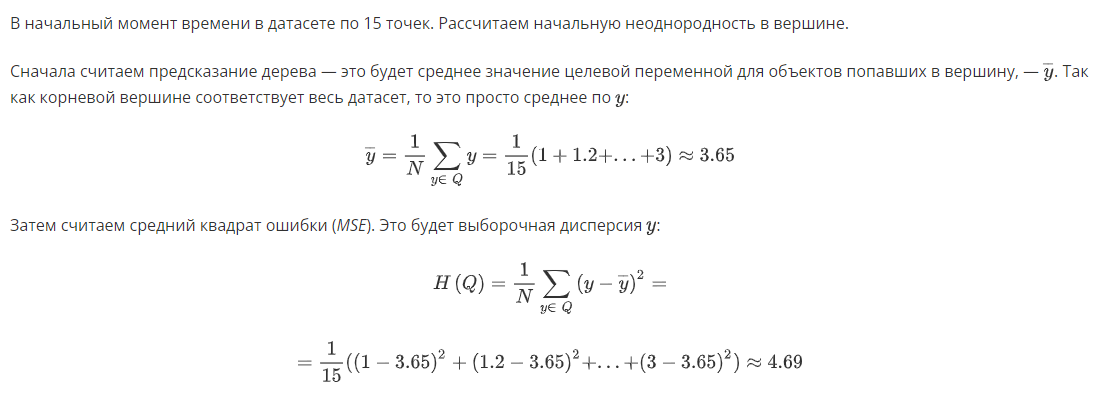

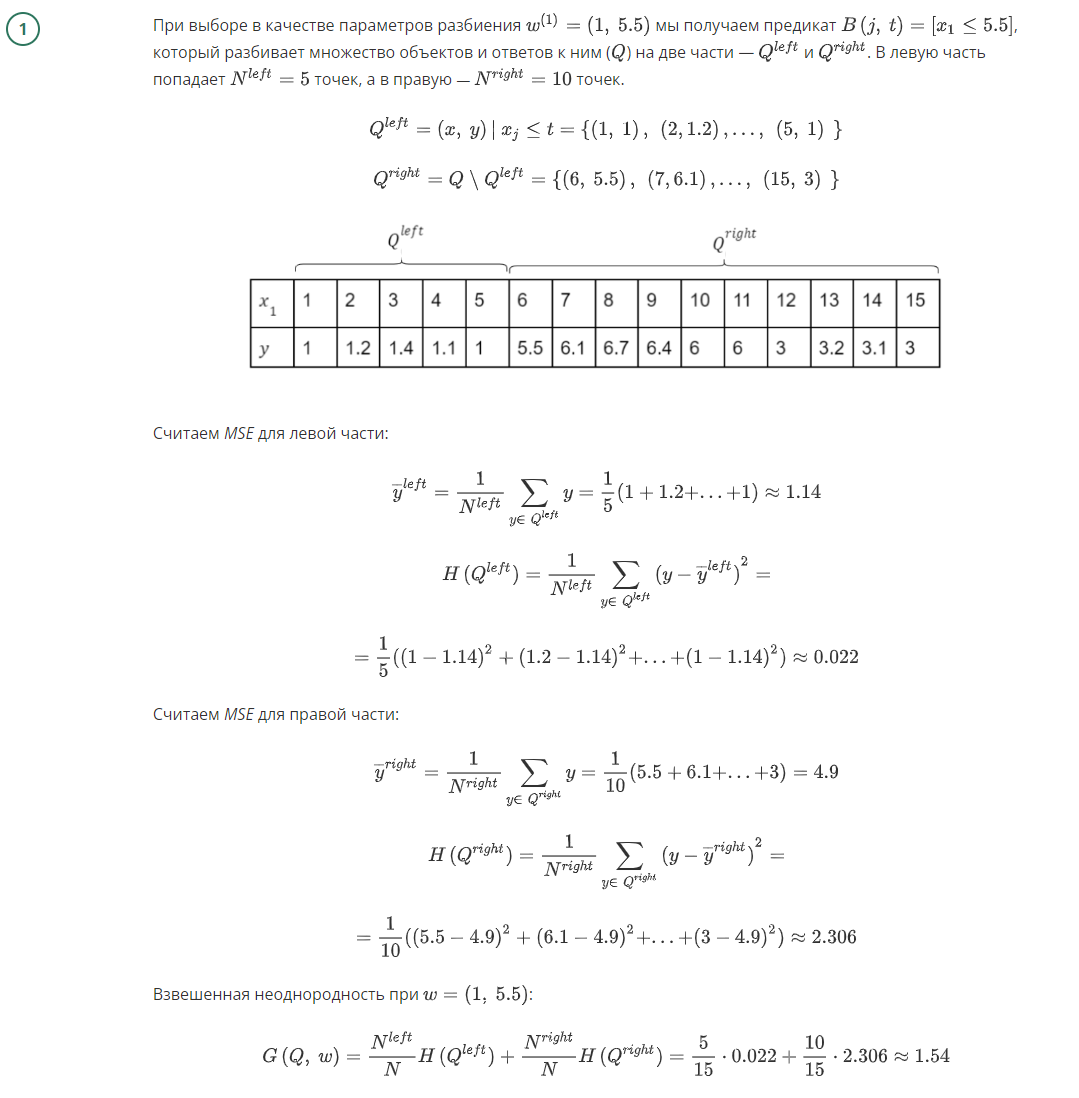

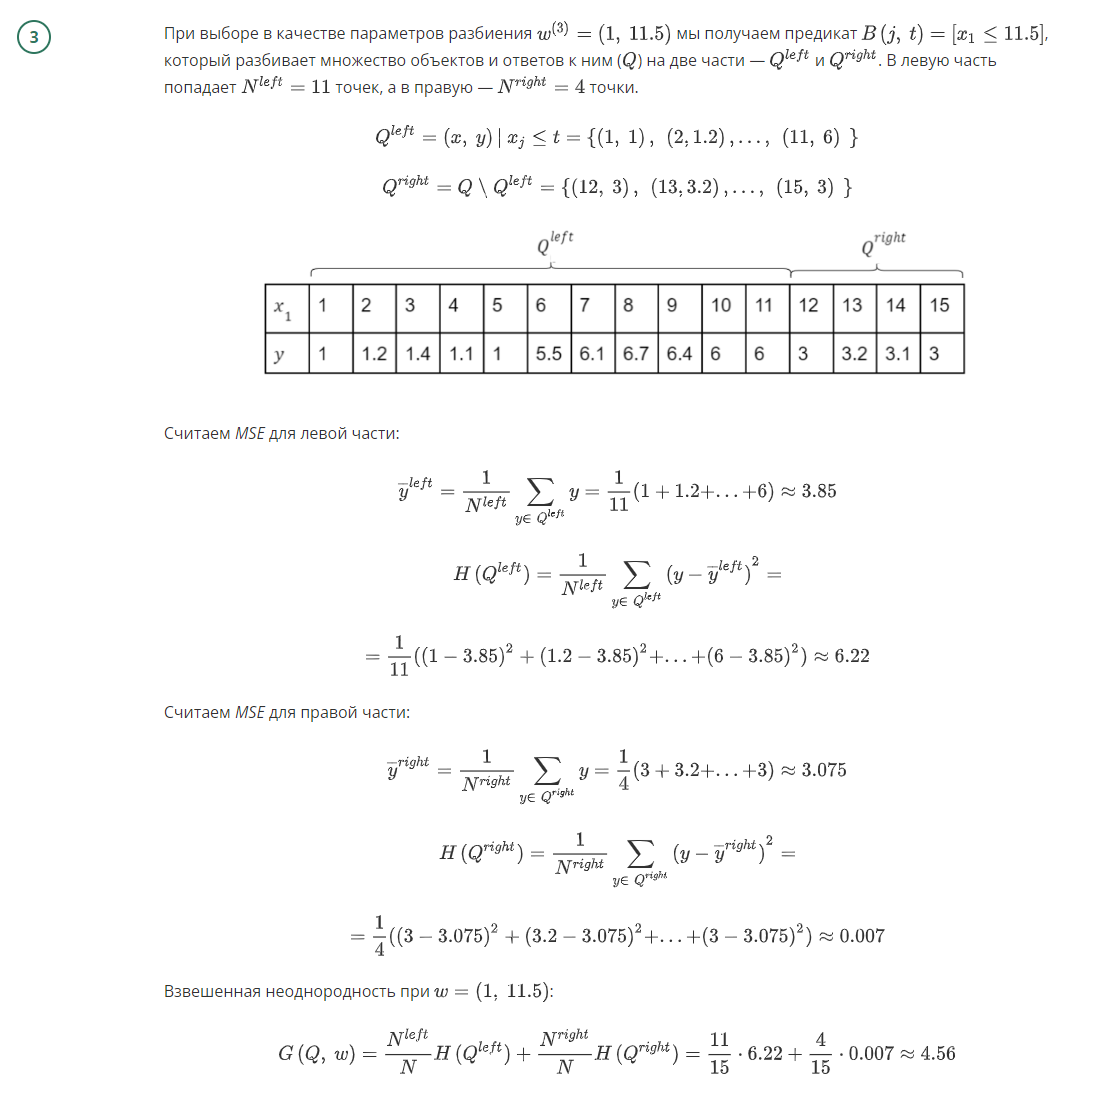

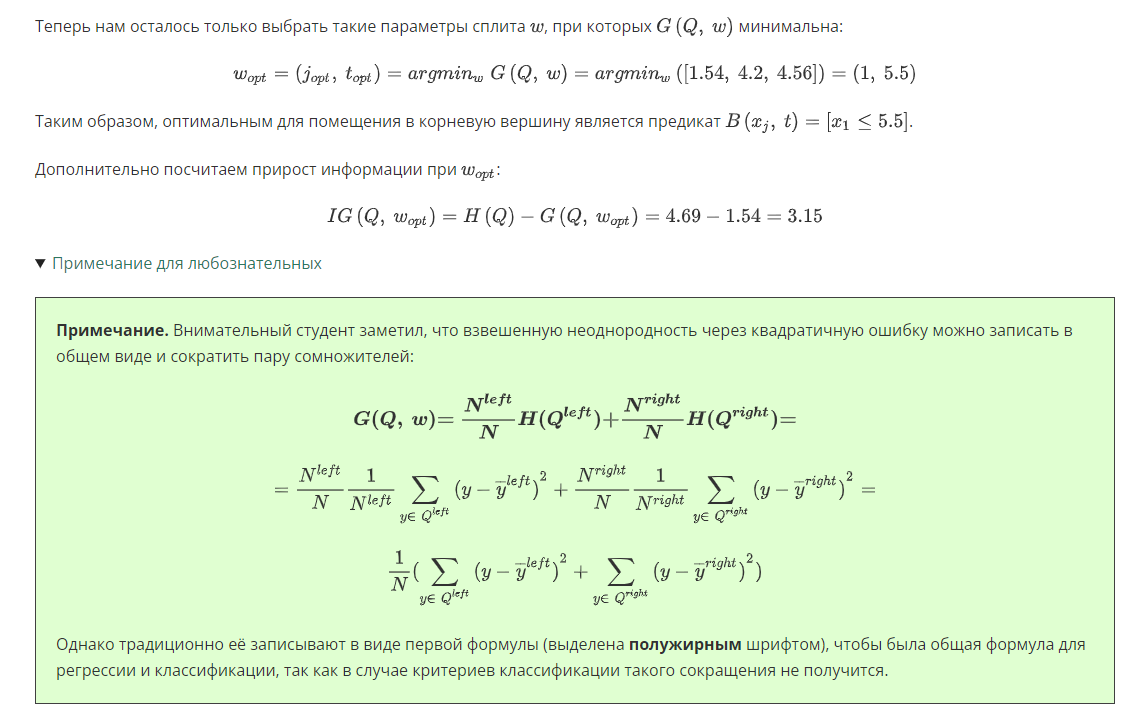

Осталось только реализовать наши формулы в виде кода.


In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import tree

def find_candidates_for_thresholds(x, y):
    x = x.sort_values().drop_duplicates()
    x_roll_mean = x.rolling(2).mean().dropna()
    y = y[x_roll_mean.index]
    y_roll_mean = y.diff()
    candidates = x_roll_mean[y_roll_mean != 0]
    return candidates.values

Для начала создадим функцию для расчёта среднего квадрата ошибки — squared_error(). Она будет принимать на вход истинные ответы и возвращать значение MSE, рассчитанное для входных данных.

In [22]:
def squared_error(y):
    y_pred = y.mean()
    return ((y - y_pred) ** 2).mean()

Далее нам необходимо реализовать функцию split(), которая разбивает выборку $(X, y)$ по предикату $[x_j <= t]$ с параметрами разделения (split_params) на левую и правую части:

In [23]:
def split(X, y, split_params):
    j, t = split_params
    predicat = X.iloc[:, j] <= t
    X_left, y_left = X[predicat], y[predicat]
    X_right, y_right = X[~predicat], y[~predicat]
    return X_left, y_left, X_right, y_right

Затем создадим функцию calculate_weighted_impurity(). Она будет принимать на вход выборку — X и y, параметры разбиения — split_params, а также criterion — функцию, по которой рассчитывается критерий информативности (у нас это функция squared_error()). Результатом работы функции будет взвешенная неоднородность после разбиения.

In [24]:
def calculate_weighted_impurity(X, y, split_params, criterion):
    X_left, y_left, X_right, y_right = split(X, y, split_params)
    N, N_left, N_right  = y.size, y_left.size, y_right.size
    score = N_left / N * criterion(y_left) + N_right / N * criterion(y_right)
    return score

Наконец, финальный шаг — построить решающий пень. Для этого необходимо оформить в виде цикла отбор кандидатов в параметры разбиения и найти оптимальные из них. За данный шаг будет отвечать функция best_split(). Она будет принимать на вход выборку (X и y) и возвращать оптимальные параметры разбиения, при которых значение взвешенной неоднородности минимально, а также значение этой неоднородности.

**Примечание.** Напомним, что сам поиск кандидатов мы реализовали в предыдущем юните в виде функции find_candidates_for_thresholds().

In [25]:
def best_split(X, y, criterion):
    M = X.shape[1]
    min_weighted_impurity = np.inf
    optimal_split_params = None
    for j in range(M):
        thresholds = find_candidates_for_thresholds(X.iloc[:, j], y)
        for t in thresholds:
            split_params = (j, t)
            weighted_impurity = calculate_weighted_impurity(X, y, split_params, criterion)
            if weighted_impurity < min_weighted_impurity:
                min_weighted_impurity = weighted_impurity
                optimal_split_params = split_params
    return optimal_split_params

Давайте протестируем функцию best_split() — возьмём датасет из нашего последнего примера:

In [26]:
data = pd.DataFrame({
    'x1': list(range(1, 16)),
    'y': [1, 1.2, 1.4, 1.1, 1, 5.5, 6.1, 6.7, 6.4, 6, 6, 3, 3.2, 3.1, 3]
})
X = data[['x1']]
y = data['y']

Чтобы найти параметры решающего пня, нам осталось только вызвать функцию best_split(), передав в неё выборку и функцию для расчёта критерия информативности:

In [27]:
# Находим оптимальные параметры разбиения
optimal_split_params = best_split(X, y, criterion=squared_error)
print('Optimal j: {}'.format(optimal_split_params[0]))
print('Optimal t: {}'.format(optimal_split_params[1]))


Optimal j: 0
Optimal t: 5.5


Мы получили следующее оптимальное решающее правило, которое разместим в корневой вершине: $B(x_j, t) = [x_1 <=5.5]$. Заметьте, что наш результат совпал с результатами ручного расчёта.

### **Примечание.** При выполнении поиска оптимальных параметров сплита возможно возникновение такой ситуации, когда взвешенная неоднородность для двух разных наборов параметров будет одинаковой. В нашей реализации такие ситуации не учитываются: выбирается первый встретившийся вариант параметров с наименьшей взвешенной неоднородностью.

### В sklearn такие случаи обрабатываются следующим образом: из всех наборов параметров разбиения, для которых неоднородность после сплита минимальна из возможных и при этом одинакова, случайным образом выбирается только один этих наборов. Поэтому иногда деревья, полученные с помощью нашего кода, и деревья из sklearn могут не совпадать. Для получения этого совпадения при работе с деревьями из sklearn необходимо задать параметр random_state. Мы будем указывать это в явном виде при формулировании заданий.

Если мы обучим на наших данных решающий пень из библиотеки sklearn с критерием информативности 'squared_error'  и параметром random_state = 0, а затем визуализируем его в виде графа, то получим ровно тот же результат:

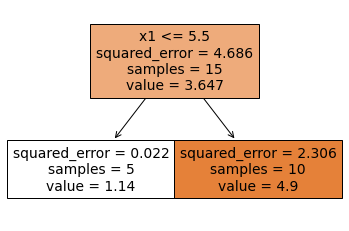

In [28]:
# Инициализируем модель дерева решений с максимальной глубиной 1 и обучаем её
dt = tree.DecisionTreeRegressor(
    max_depth=1, #глубина
    criterion='squared_error', #критерий информативности
    random_state=0 #генератор случайных чисел
)

dt.fit(X, y)
# Визуализируем дерево решений в виде графа
tree.plot_tree(
    decision_tree=dt, #дерево решений 
    feature_names=X.columns, #названия факторов
    filled=True, #расцветка
    impurity=True, #отображать ли неоднородность в вершинах
);

### Примечание. Обратите внимание, что значение squared_error в визуализации графа в sklearn считается отдельно для каждой вершины до произведения разделения. Например, в корневой вершине squared_error=4.686 — значение квадрата ошибки до произведения разделения. Точно такое же значение (с точностью до сотых) у нас получалось при ручном подсчёте.

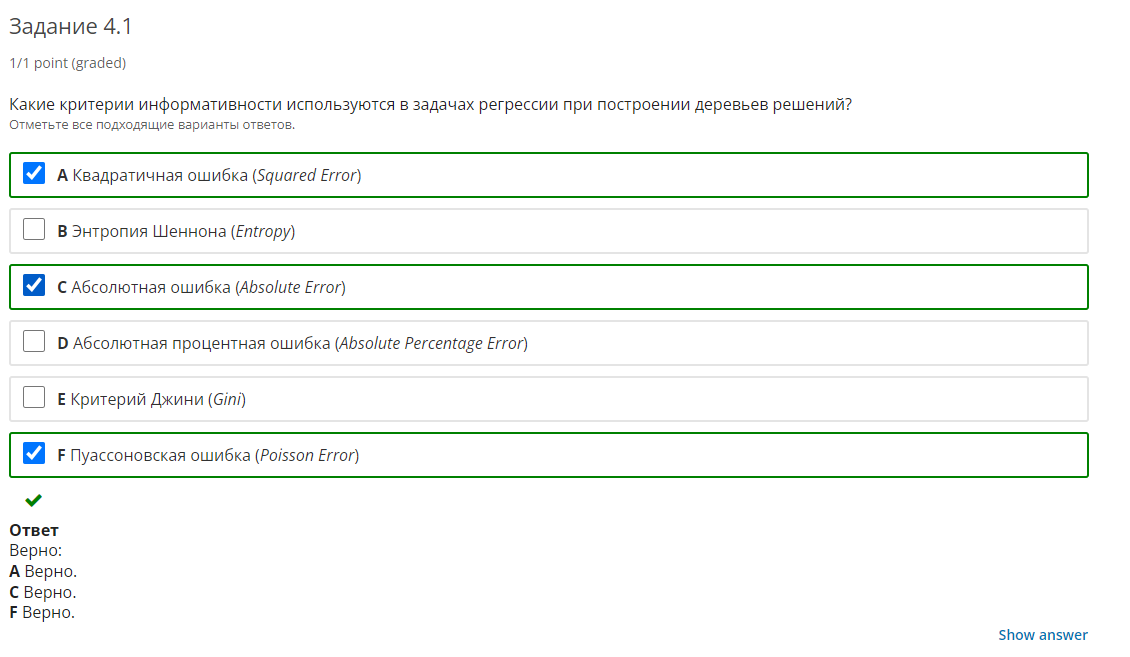

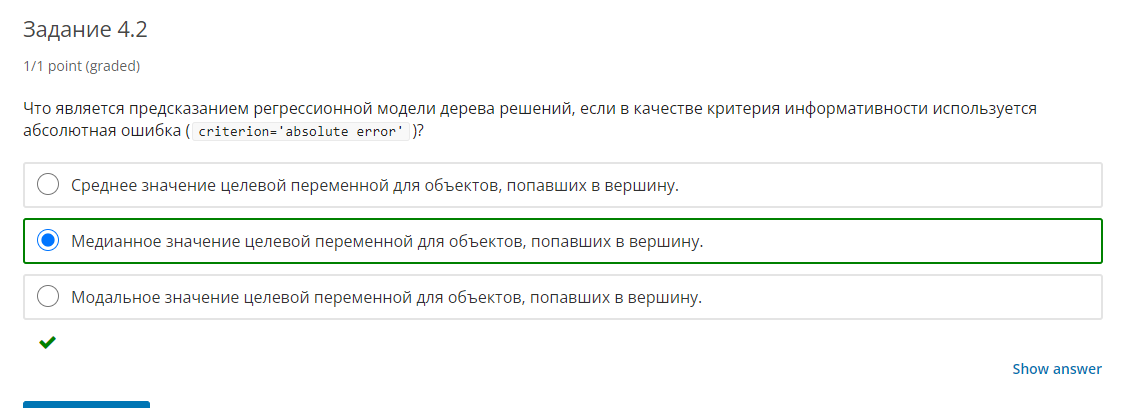

## Задание 4.3

Дана часть датасета о домах в штате Айова, состоящая из 15 наблюдений:

In [29]:
ames_data = pd.read_csv('data/AmesHousing.csv')
ames_data = ames_data[(ames_data["Lot Frontage"] <= 150) & (ames_data["Lot Area"] <= 20000)]

ames_sample = ames_data[["Lot Frontage", "Lot Area", "SalePrice"]].sample(
    n=15, random_state=42, ignore_index=True
)

X = ames_sample[["Lot Frontage", "Lot Area"]]
y = ames_sample["SalePrice"]

Найдите оптимальные для построения решающего пня параметры разбиения $j$ и $t$. В качестве критерия информативности используйте квадратичную ошибку.

Если вы хотите попрактиковаться в использовании формул, можно проделать операцию построения дерева решений вручную.

Примечание. Для самопроверки обучите на данной части датасета дерево решений из sklearn с максимальной глубиной 1, критерием информативности 'squared_error' и параметром random_state = 0 и визуализируйте его граф.

1. На основе какого фактора $x_j$ будет построено решающее правило в корневой вершине?
2. Чему равно оптимальное пороговое значение $t$? Ответ приведите в виде целого числа.
3. Чему равно значение взвешенной неоднородности после разбиения при найденных оптимальных параметрах сплита? Ответ округлите до целого числа.

Optimal j: 0
Optimal t: 71
Weighted impurity: 1414654917


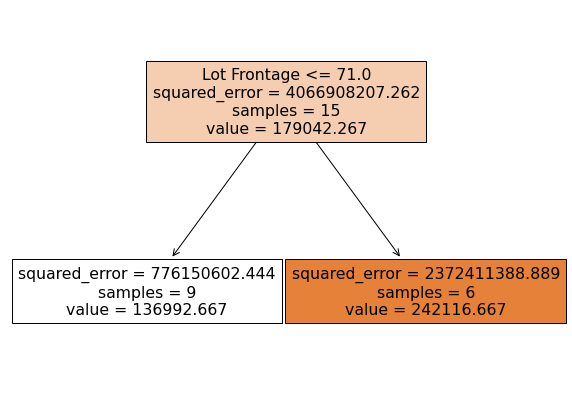

In [30]:
# Находим оптимальные параметры разбиения
optimal_params = best_split(X, y, criterion=squared_error)
print('Optimal j: {}'.format(optimal_params[0]))
print('Optimal t: {:.0f}'.format(optimal_params[1]))
print('Weighted impurity: {:.0f}'.format(calculate_weighted_impurity(X, y, optimal_params, criterion=squared_error)))

# Инициализируем модель дерева решений с максимальной глубиной 1 и обучаем её
dt = tree.DecisionTreeRegressor(max_depth=1, criterion='squared_error', random_state=0)
dt.fit(X, y)
# Визуализируем дерево решений в виде графа
fig = plt.figure(figsize = (10, 7))
tree.plot_tree(
    decision_tree=dt, #дерево решений 
    feature_names=X.columns, #названия факторов
    filled=True, #расцветка
    impurity=True, #отображать ли неоднородность в вершинах
);

# **КРИТЕРИИ ИНФОРМАТИВНОСТИ В ЗАДАЧЕ КЛАССИФИКАЦИИ**

Все критерии для задачи классификации, которые мы будем рассматривать, основаны на вероятности принадлежности к классу. Пусть у нас есть $K$ классов. Тогда оценка вероятности принадлежности к классу под номером $k$ определяется как:

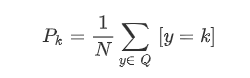


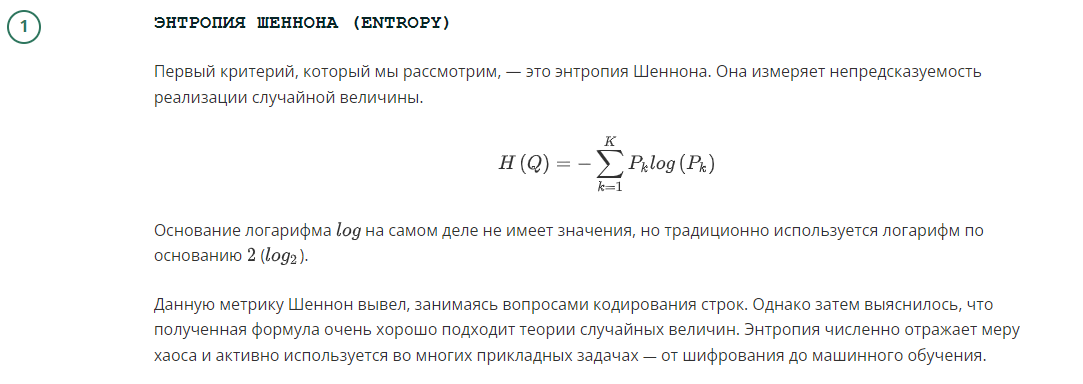

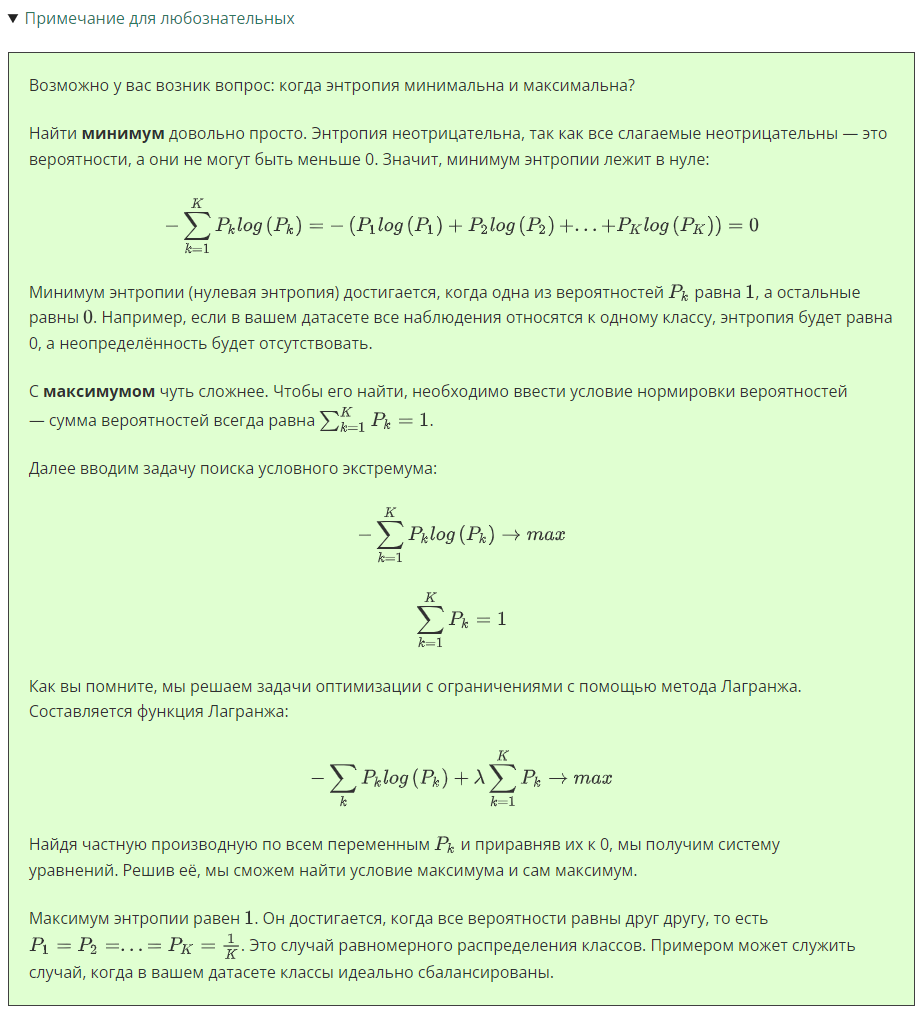

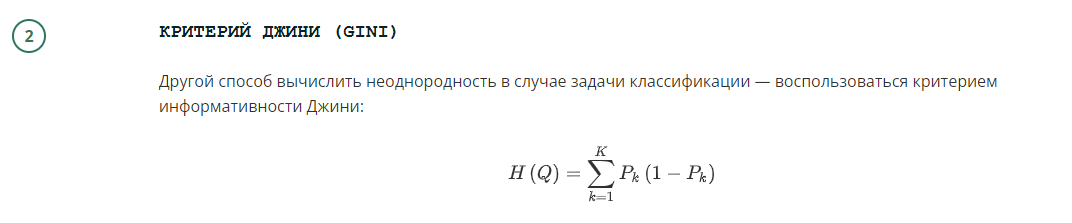

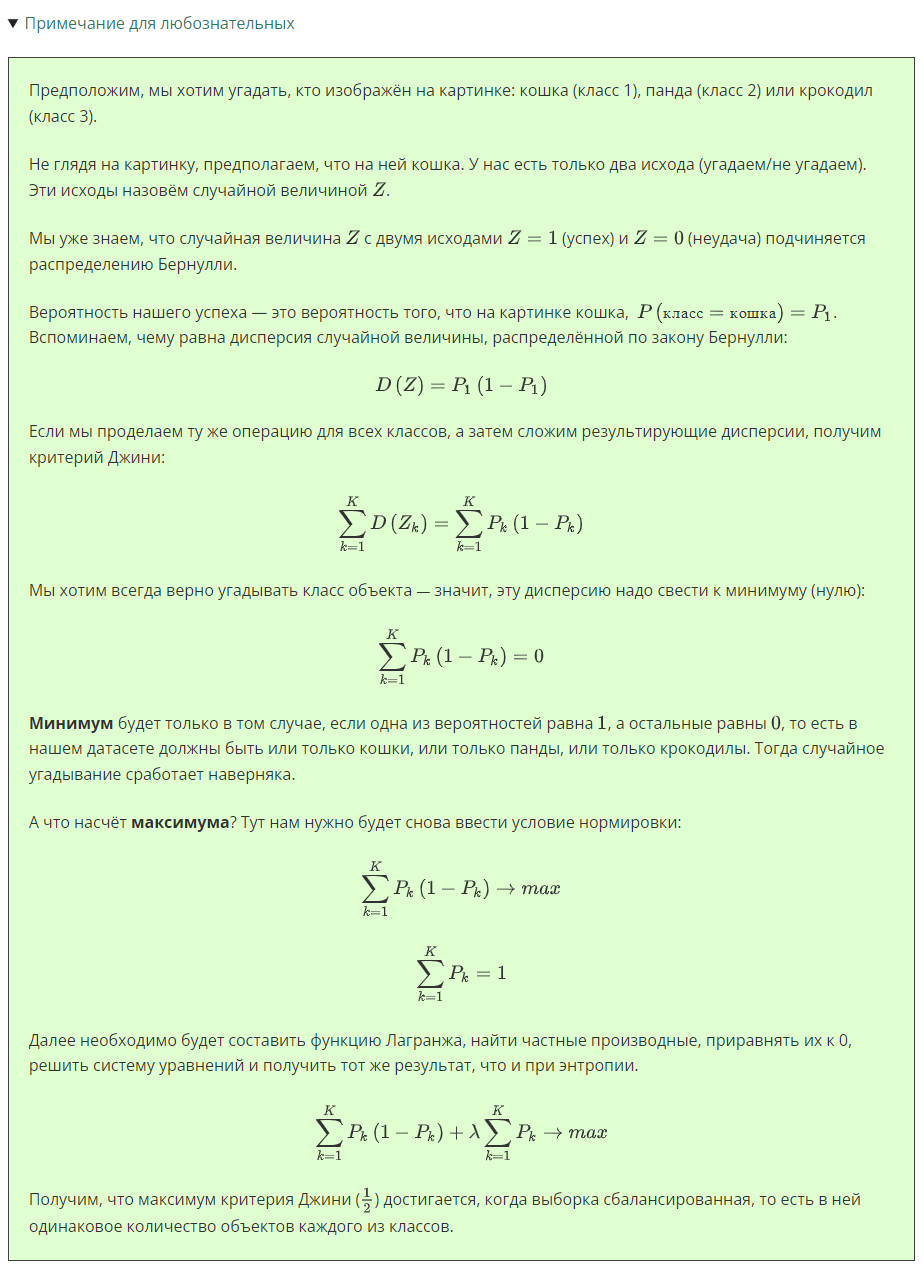

Теперь давайте на примере энтропии рассмотрим, как работают введённые нами критерии информативности для задачи классификации ↓

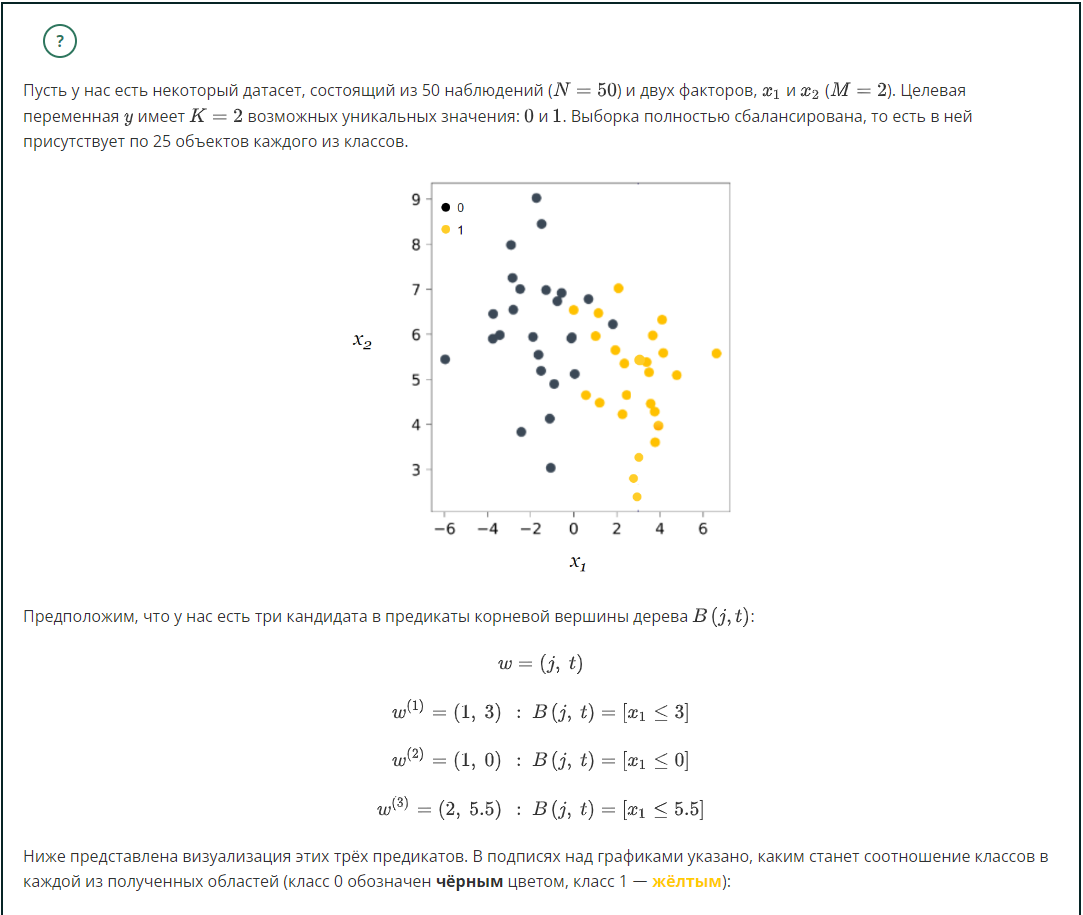
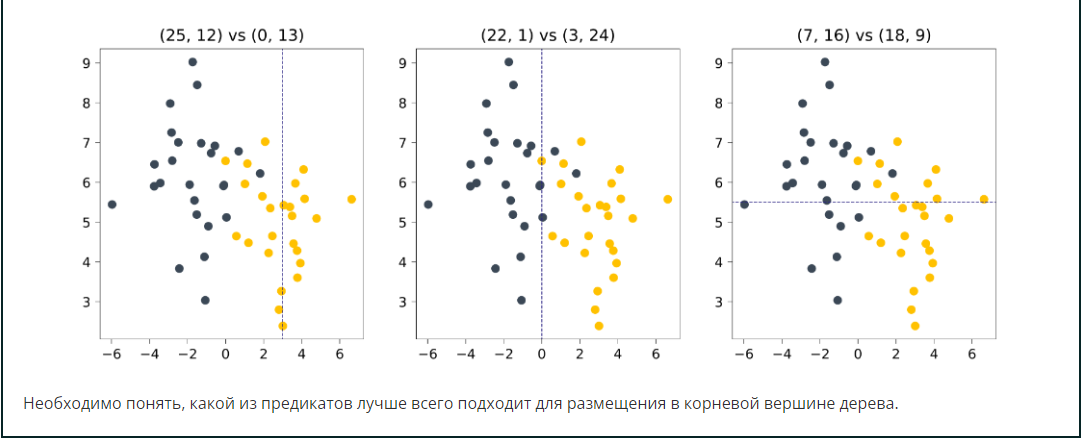

### **Примечание.** Без всякой математики видно, что наилучшим является разделение по предикату $[x_1 <= 0]$ — оно обеспечивает практически идеальное разделение на классы.

Однако это очевидно лишь для того, кто смотрит на график. Давайте проследим, как к этому же утверждению придёт дерево решений.

В начальный момент времени в датасете есть по 25 точек каждого из классов.

Энтропия начального состояния равна:

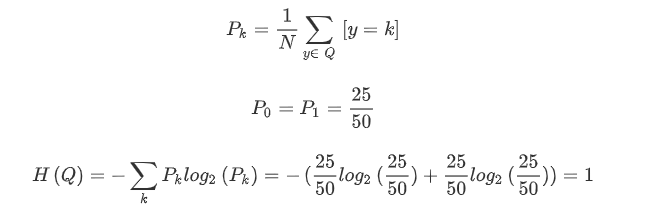

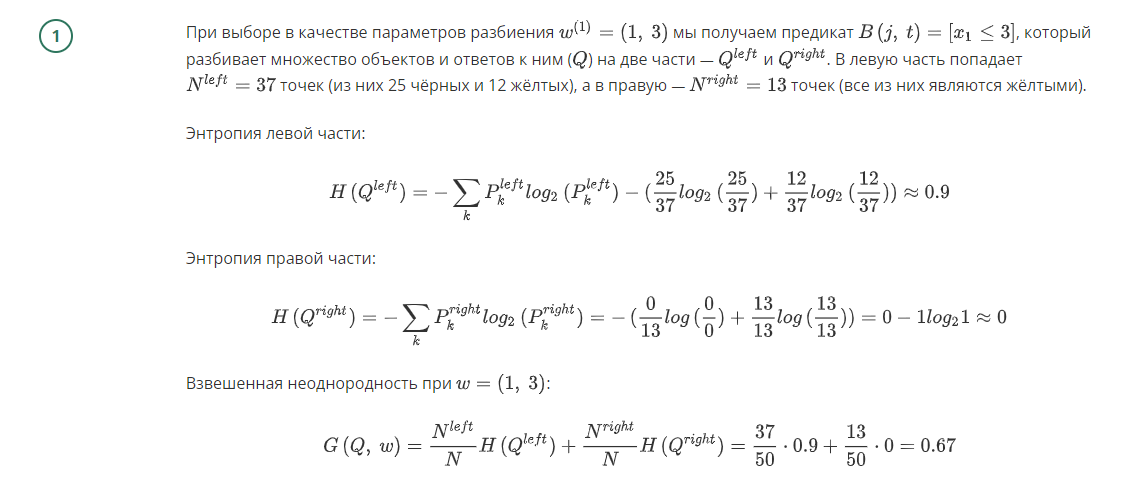
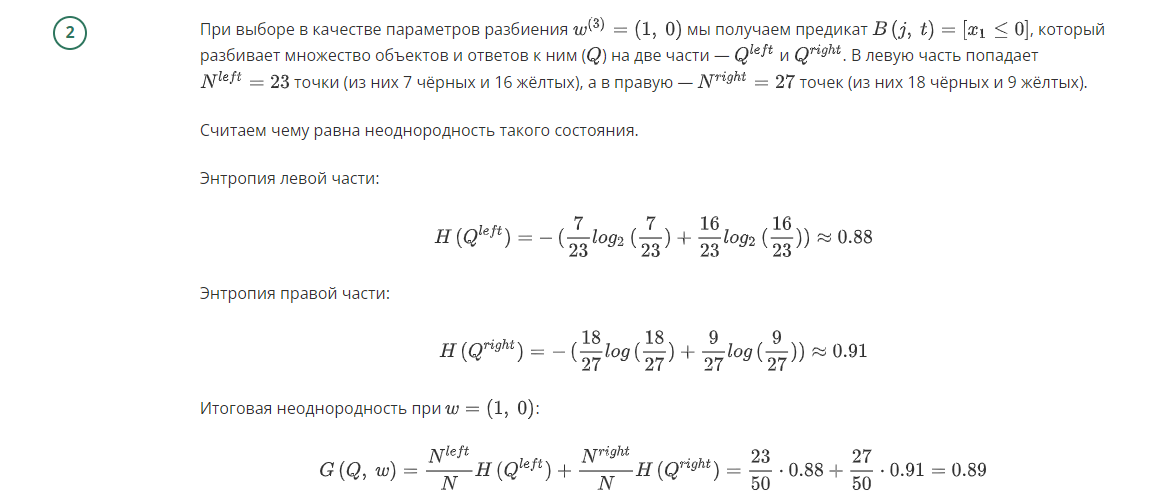
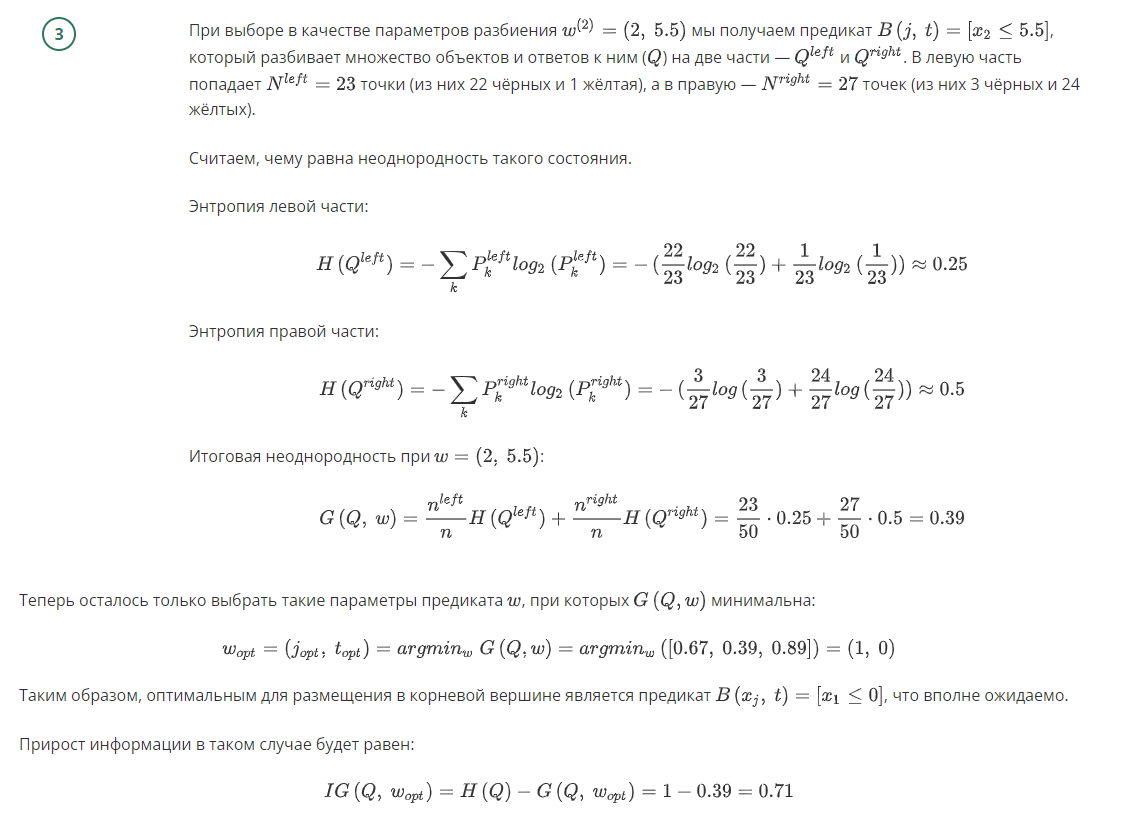

А что насчёт кода? Как изменится код для поиска оптимальных параметров разбиения для задачи классификации?

Сам алгоритм не изменится — просто вместо расчёта квадратичной ошибки мы будем рассчитывать критерий информативности для классификации, например энтропию.

Реализуем функцию entropy(), которая рассчитывает энтропию Шеннона. На вход функции приходит целевая переменная $y$. Далее с помощью функции value_counts() считаются доли каждого из классов — вероятности принадлежности к классам. Затем эти вероятности логарифмируются по основанию 2, и наконец по приведённой выше формуле рассчитывается энтропия.

In [31]:
def entropy(y):
    p = y.value_counts(normalize=True)
    entropy = -np.sum(p * np.log2(p))
    return entropy

Для вызова самой функции best_split() нужно будет только поменять критерий информативности (параметр criterion). Пример:

In [33]:
optimal_params = best_split(X, y, criterion=entropy)
print('Optimal j: {}'.format(optimal_params[0]))
print('Optimal t: {}'.format(optimal_params[1]))

Optimal j: 0
Optimal t: 65.0


## Задание 4.4

Какие критерии информативности используются в задачах классификации при построении деревьев решений?

+ Энтропия Шеннона (Entropy)
+ Критерий Джини (Gini)

## Задание 4.5

Дана часть датасета о банкнотах, состоящая из 15 наблюдений:

In [35]:
bill_data = pd.read_csv('data/bill_authentication.csv')
bill_sample = bill_data[['Variance', 'Skewness', 'Class']].sample(
    n=15, 
    random_state=42, 
    ignore_index=True
)
# Создаём обучающую выборку
X = bill_sample[['Variance', 'Skewness']]
y = bill_sample['Class']

Найдите оптимальные для построения решающего пня параметры разбиения $j$ и $t$. Для этого воспользуйтесь функцией best_split(), которую мы реализовали ранее. В качестве критерия информативности используется энтропию Шеннона.

Если вы хотите попрактиковаться в использовании формул, можно проделать операцию построения дерева решений вручную.

**Примечание.** Для самопроверки обучите на данной части датасета дерево решений из sklearn с максимальной глубиной 1, критерием информативности 'entropy' и параметром random_state = 0 и визуализируйте его граф.

Optimal j: 1
Optimal t: 3.221
Impurity: 0.460


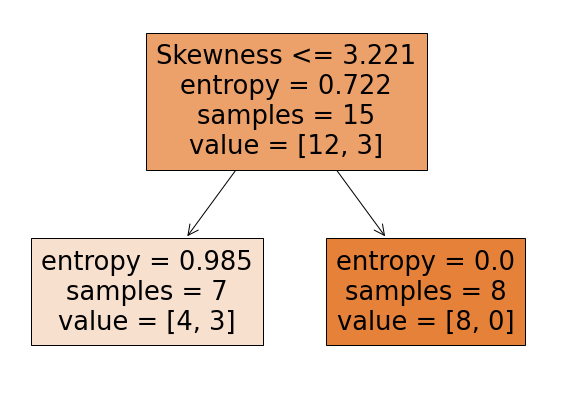

In [36]:
# Находим оптимальные параметры разбиения
optimal_params = best_split(X, y, criterion=entropy)
print('Optimal j: {}'.format(optimal_params[0]))
print('Optimal t: {:.3f}'.format(optimal_params[1]))
print('Impurity: {:.3f}'.format(calculate_weighted_impurity(X, y, optimal_params, criterion=entropy)))

# Инициализируем модель дерева решений с максимальной глубиной 1 и обучаем её
dt = tree.DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=0)
dt.fit(X, y)
# Визуализируем дерево решений в виде графа
fig = plt.figure(figsize = (10, 7))
tree.plot_tree(
    decision_tree=dt, #дерево решений 
    feature_names=X.columns, #названия факторов
    filled=True, #расцветка
    impurity=True, #отображать ли неоднородность в вершинах
);

# **ПАРАЛЛЕЛЬНЫЕ ВЫЧИСЛЕНИЯ НЕОДНОРОДНОСТИ**

Вероятно, вы заметили, что вычисление оптимальных параметров разбиения внутри вершины дерева — очень утомительная операция со множеством громоздких формул и вычислений.

### Мы рассмотрели два «игрушечных» примера построения корневой вершины дерева для задач регрессии и классификации. При этом мы брали всего по три возможных кандидата в предикаты. В реальности данных и кандидатов в параметры разбиения значительно больше. Представьте, сколько вычислений производит компьютер при построении, казалось бы, простой модели дерева решений.

Внимательный студент заметил, что взвешенную неоднородность $G(Q, w)$ для каждого случая параметров $w$ мы считали отдельно, то есть независимо, а уже затем из полученных результатов выбирали минимум.

⭐ Идея! Раз все вычисления производятся на компьютере, можно использовать **параллельные вычисления на многоядерном процессоре** и считать неоднородность $G(Q, w)$ для каждой комбинации $w$ параллельно с другими, тем самым значительно повышая скорость построения дерева решений. Эта идея активно используется во многих библиотечных реализациях алгоритма CART, включая sklearn.